In [1]:
import os 
os.chdir("..")


In [18]:
%load_ext autoreload
%autoreload 2
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time
from scipy.special import erf
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

mode = "damping"
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

dtt = 1e-6
total_time = 4.
total_time, dt = get_total_time_dt(params, dt=dtt, total_time=total_time)
times = np.arange(0, total_time+ dt, dt)



Ntraj = 2000
boundsB= np.arange(.5,4.5,.1)


stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]

er=[]
deter = {}
deter["h0/h1"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(times)+1))

indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]



n=1
ers = []
for itraj in tqdm(range(1,Ntraj)):
    try:

        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj, mode=mode, dtt=dtt, total_time=total_time)

        for indb,b in enumerate(boundsB):
            stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, times))
            stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,times))

            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b
                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
        ers.append(itraj)
l0/=(Ntraj - len(ers))
l1/=(Ntraj - len(ers))

 88%|████████▊ | 1751/1999 [22:41<05:22,  1.30s/it]

In [33]:
stops = []
for k in stop["_1"].values():
    if len(k) != 0:
        stops.append(k)
stops = np.squeeze(stops)


cons = []
anals = []
timbin = []
timanals = []
for indb, b in enumerate(boundsB):

    counts, bins = np.histogram(stops[:,indb], 50, normed=True)
    timms = np.linspace(0,np.max(bins), 100)
    gp1 =[prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in timms]
    timbins = .5*(bins[1:] + bins[:-1])
    cons.append(counts)
    anals.append(gp1)
    timbin.append(timbins)
    timanals.append(timms)

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/nfs/pic.es/user/m/mbilkis/continuous/numerics/utilities/misc.py:142: RuntimeWarning: divide by zero encountered in double_scalars
/nfs/pic.es/user/m/mbilkis/continuous/numerics/utilities/misc.py:142: RuntimeWarning: invalid value encountered in double_scalars


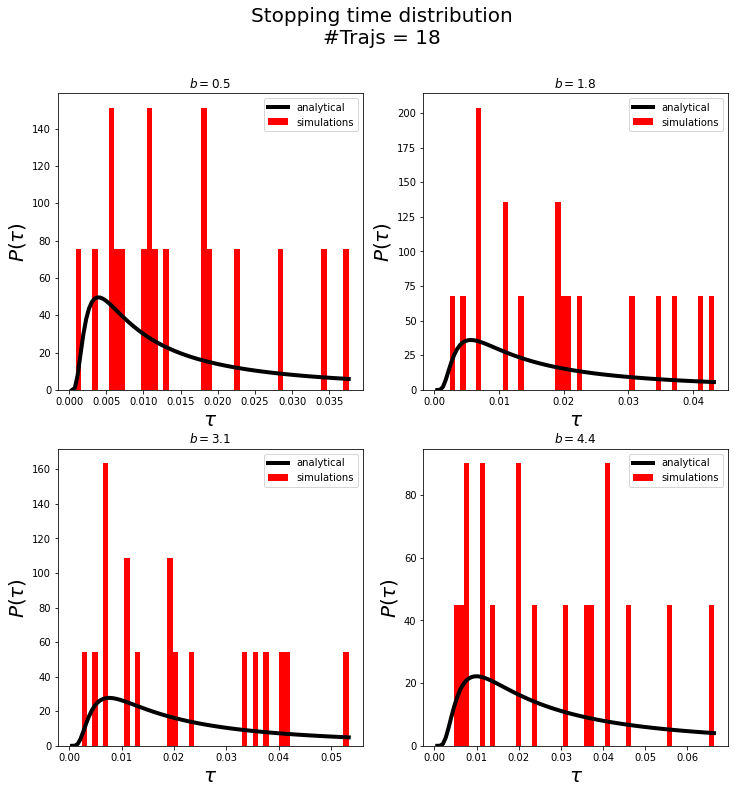

In [23]:
plt.figure(figsize=(12,12))
plt.suptitle("Stopping time distribution\n#Trajs = {}".format(len(stops)),size=20)
axx = [221, 222, 223, 224]
selected_b = [boundsB[int(k)] for k in np.linspace(0,len(boundsB)-1, 4)]
for indb, b in enumerate(selected_b):
    ax = plt.subplot(axx[indb])
    ax.set_title('$b=$'+str(np.round(b,2)))
    ax.plot(timanals[indb], anals[indb], linewidth=4, color="black", label="analytical")
    ax.bar(timbin[indb], cons[indb], width=timbin[indb][1]-timbin[indb][0], color="red", label="simulations")
    ax.set_xlabel(r'$\tau$',size=20)
    ax.set_ylabel(r'$P(\tau)$', size=20)
    ax.legend(prop={"size":10})
